# Simply Neural Netowork for Classification

## 0 - Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

In [3]:
np.random.seed(12)

In [4]:
def plot_decision_boundary(model, X, y):
    # Get min and max for each feature
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Generate a grid for plotting
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
    # Predict the function value for the whole grid
    Z = model(np.c_[x1.flatten(), x2.flatten()])
    Z = Z.reshape(x1.shape)
    # Plot the contour and training examples
    plt.contourf(x1, x2, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

## 1 - Artificial Data Generation

Generate the data that is not linearly separable

In [5]:
num_samples, num_feature = 400, 2
X = np.zeros((num_samples, num_feature))
Y = np.zeros((num_samples, 1))
num_samples_per_class = num_samples // 2

for i in range(2):
    idx = range(num_samples_per_class * i, num_samples_per_class * (i + 1))
    t = np.linspace(i * 3, (i + 1) * 3, num_samples_per_class) + np.random.randn(num_samples_per_class) * 0.2
    r = 4 * np.sin(4 * t) + np.random.randn(num_samples_per_class) * 0.2
    X[idx] = np.c_[r * np.sin(t), r * np.cos(t)]
    Y[idx] = i

## 2 - Data Examination

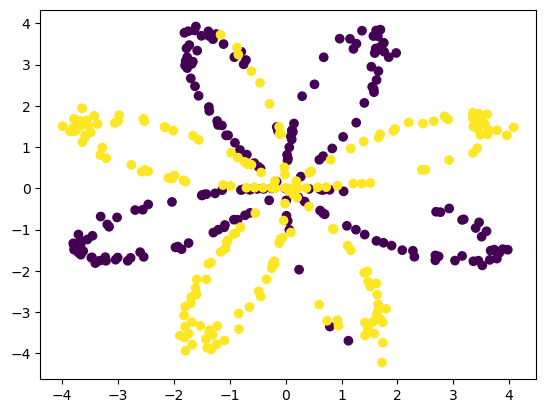

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

In [7]:
num_sample, num_feature = X.shape[0], X.shape[1]

In [8]:
num_sample, num_feature

(400, 2)

## 3 - Try Logistic Regression

In [9]:
clf = sklearn.linear_model.LogisticRegressionCV(random_state=0)
clf.fit(X, np.squeeze(Y))

LogisticRegressionCV(random_state=0)

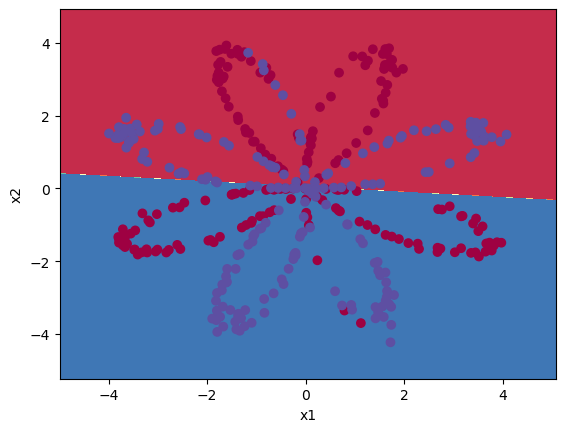

In [10]:
def logistic_model(x):
    return clf.predict(x)
plot_decision_boundary(logistic_model, X, Y)

As we can see, logistic regression fails to classify two groups of samples.

## 4 - Fully Connected Neural Network

Let's create a neural network with:

- Input layer with `2` neurons
- Hidden layer with `6` neurons with `tanh` activation functions
- Output layer with `1` neurons with `sigmoid` activation function

For each sample $x^{(i)}$, it undergoes the following transformation: (the superscript $^{[i]}$ stands for the $i$-th layer. Input layer is counted as 0)

$$
\vec{z}^{[1](i)} = W^{[1]} \cdot \vec{x}^{(i)} + \vec{b}^{[1]}
$$

$$
\vec{a}^{[1] (i)} = \text{tanh}(\vec{z}^{[1] (i)})\tag{2}
$$

$$
\vec{z}^{[2](i)} = W^{[2]} \cdot \vec{a}^{[1](i)} + \vec{b}^{[2]}
$$

$$
\hat{y}^{(i)} = \vec{a}^{[2] (i)} = \text{sigmoid}(\vec{z}^{[2](i)})
$$

For better notation, each variable dimension is denoted as follows (vector is preferred to be a column vector):

- $\vec{x}^{(i)}$: (2, 1)
- $W^{[1]}$: (6, 2)
- $\vec{b}^{[1]}$: (6, 1)
- $\vec{z}^{[1](i)}$: (6, 1)
- $\vec{a}^{[1] (i)}$: (6, 1)
- $W^{[2]}$: (1, 6)
- $\vec{b}^{[2]}$: (1, 1)
- $\vec{z}^{[2](i)} $: (1, 1)
- $\hat{y}^{(i)}$: (1, 1)

To measure how close our prediction it close to the ground truth, the following loss function is adopted for a single sample:

$$
L(\hat{y}^{(i)}, y^{(i)}) = - y^{(i)} \cdot \log(\hat{y}^{(i)}) - (1-y^{(i)}) \cdot \log(1-\hat{y}^{(i)})
$$

By considering all samples, the loss function will be:

$$
J = \frac{1}{n} \sum_{i=1}^{n} L(\hat{y}^{(i)}, y^{(i)})
$$

## 5 - Neural Network Implementation - Functions

When implementing the neural network, we should leverge vectorization, the neural network architecture will become:

$$
Z^{[1]} = W^{[1]} X + \vec{b}^{[1]}
$$

$$
A^{[1]} = \text{tanh}(Z^{[1]})
$$

$$
Z^{[2]} = W^{[2]} A^{[1]} + \vec{b}^{[2]}
$$

$$
\hat{Y} = A^{[2]} = \text{sigmoid}(Z^{[2]})
$$

The dimension is listed as bellow:

- $W^{[1]}$: (6, 2)
- $X$: (2, num_samples)
- $\vec{b}^{[1]}$: (6, 1)
- $Z^{[1]}$: (6, num_samples)
- $A^{[1]}$: (6, num_samples)
- $W^{[2]}$: (1, 6)
- $\vec{b}^{[2]}$: (1, 1)
- $Z^{[2]}$: (1, num_samples)
- $\hat{Y}$: (1, num_samples)

In order to use gradient, the following derivatives are computed using vectorization format:

$$
\frac{\partial J}{\partial Z^{[2]}} = A^{[2]} - Y 
$$

$$
\frac{\partial J}{\partial W^{[2]}} = \frac{\partial J}{\partial Z^{[2]}} \frac{\partial Z^{[2]}}{\partial W^{[2]]}} = \frac{1}{n}\frac{\partial J}{\partial Z^{[2]}} A^{[1]T}
$$

The `sum` below is along the dimension of `num_samples`
$$
\frac{\partial J}{\partial \vec{b}^{[2]}} = \frac{\partial J}{\partial Z^{[2]}} \frac{\partial Z^{[2]}}{\partial \vec{b}^{[2]}} = \frac{1}{n} \text{sum}(\frac{\partial J}{\partial Z^{[2]}})
$$

The $A^{[1]} \cdot A^{[1]}$ stands for element-wise product
$$
\frac{\partial J}{\partial {Z^{[1]}}} = \frac{\partial J}{\partial {Z^{[2]}}} \frac{\partial Z^{[2]}}{\partial A^{[1]}} \frac{\partial A^{[1]}}{\partial Z^{[1]}} = W^{[2]T} (A^{[2]} - Y) (1 - A^{[1]} \cdot A^{[1]}) = W^{[2]T} \frac{\partial J}{\partial Z^{[2]}} (1 - A^{[1]} \cdot A^{[1]})
$$

$$
\frac{\partial J}{\partial {W^{[1]}}} = \frac{\partial J}{\partial {Z^{[2]}}} \frac{\partial Z^{[2]}}{\partial {A^{[1]}}} \frac{\partial A^{[1]}}{\partial {Z^{[1]}}}  \frac{\partial Z^{[1]}}{\partial {W^{[1]}}} = \frac{1}{n} \frac{\partial J}{\partial Z^{[1]}} X^T
$$

The `sum` below is along the dimension of `num_samples`
$$
\frac{\partial J}{\partial {\vec{b}^{[1]}}} = \frac{1}{n} \text{sum}\frac{\partial J}{\partial Z^{[1]}} 
$$

In [11]:
# Transform for better vectorization
X, Y = X.T, Y.T

`sigmoid` function

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

`init_param` function to initialize parameters

In [13]:
def init_param(input_size: int=2, hidden_size: int=6, output_size: int=1):
    """
    Argument:
    input_size: number of neurons in the input layer
    hidden_size: number of neurons in the hidden layer
    output_size: number of neurons in the output layer
    
    Returns:
    params: {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    """
    W1 = np.random.randn(hidden_size, input_size) * 0.01
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size) * 0.01
    b2 = np.zeros((output_size, 1))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

`forward` function to compute loss and gradient

In [14]:
def forward(X: np.ndarray, parameters: dict):
    """
    Argument:
    X: (2, num_samples)
    parameters: {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    Returns:
    Y_hat: (1, num_samples)
    cache: {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    """
    # Get parameters
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
    # Forward calculation
    Z1 = np.matmul(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.matmul(W2, A1) + b2
    A2 = sigmoid(Z2)
    Y_hat = A2
    # Save for return
    cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    return Y_hat, cache

`compute_loss` function to calculate the loss

In [15]:
def compute_loss(Y_hat: np.ndarray, Y: np.ndarray):
    """
    Arguments:
    Y_hat: (1, num_samples)
    Y: (1, num_samples)

    Returns:
    loss: float
    """
    num_samples= Y_hat.shape[1]
    loss = 1 / num_samples * np.sum(- np.dot(Y, np.log(Y_hat.T)) - np.dot((1 - Y), np.log(1 - Y_hat.T)))
    return loss

`backward` function to calculate the gradient

In [16]:
def backward(X: np.ndarray, Y: np.ndarray, parameters: dict, cache: dict):
    """
    Arguments:
    X: (2, num_samples)
    Y: (1, num_samples)
    parameters: {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    cache: {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    
    Returns:
    grads: {'dW1': dW1, 'db1', db1, 'dW2': dW2, 'db2': db2}
    """
    num_samples = X.shape[1]
    # Get necessary parameters
    W1, W2 = parameters['W1'], parameters['W2']
    # Get intermdiate variables
    A1, A2 = cache['A1'], cache['A2']
    # Calculate the gradient using chain rule
    dZ2 = A2 - Y
    dW2 = 1 / num_samples * np.matmul(dZ2, A1.T)
    db2 = 1 / num_samples * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.matmul(W2.T, dZ2) * (1 - np.power(A1, 2)) 
    dW1 = 1 / num_samples * np.matmul(dZ1, X.T)
    db1 = 1 / num_samples * np.sum(dZ1, axis=1, keepdims=True)
    # Save for return
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return grads

`update_param` to update parameters

In [17]:
def update_param(parameters: dict, grads: dict, learning_rate: float=1e-3):
    """
    Arguments:
    parameters: {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    grads: {'dW1': dW1, 'db1', db1, 'dW2': dW2, 'db2': db2}
    """
    # Get parameters
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
    # Get gradient
    dW1, db1 = grads['dW1'], grads['db1']
    dW2, db2 = grads['dW2'], grads['db2']
    # Update the parameters using gradient descent
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    # Save for return
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

`predict` to predict the labels

In [18]:
def predict(parameters: dict, X: np.ndarray):
    Y_hat, _ = forward(X, parameters)
    Y_pred = np.where(Y_hat > 0.5, 1, 0)
    return Y_pred

## 6 - Neural Network Implementation - Model

Combine all functions together to construct the model

In [19]:
def nn_model(X: np.ndarray, Y: np.ndarray, learning_rate: float=1.5, max_iteration:int = 20000):
    """
    Arguments:
    X: (2, num_samples)
    Y: (1, num_samples)
    learning_rate: float

    Returns: 
    parameters: {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    Y_pred: (1, num_samples)
    """
    # Step - 1: initialize parameters
    parameters = init_param(2, 6, 1)
    for idx in range(0, max_iteration): 
        # Step - 2: forward
        A2, cache = forward(X, parameters)
        # Step - 3: loss
        loss = compute_loss(A2, Y)
        # Step - 4: calculate gradients
        grads = backward(X, Y, parameters, cache)
        # Step - 5: update parameters
        parameters = update_param(parameters, grads, learning_rate)
        # Print the cost every 1000 iterations
        if idx % 1000 == 0:
            print ("Cost after iteration %i: %f" %(idx, loss))
    
    return parameters

In [20]:
parameters = nn_model(X, Y)

Cost after iteration 0: 0.693233
Cost after iteration 1000: 0.183393
Cost after iteration 2000: 0.129773
Cost after iteration 3000: 0.113153
Cost after iteration 4000: 0.104146
Cost after iteration 5000: 0.097885
Cost after iteration 6000: 0.093178
Cost after iteration 7000: 0.091725
Cost after iteration 8000: 0.089446
Cost after iteration 9000: 0.087492
Cost after iteration 10000: 0.085798
Cost after iteration 11000: 0.084313
Cost after iteration 12000: 0.082997
Cost after iteration 13000: 0.081824
Cost after iteration 14000: 0.080770
Cost after iteration 15000: 0.079819
Cost after iteration 16000: 0.078956
Cost after iteration 17000: 0.078169
Cost after iteration 18000: 0.077449
Cost after iteration 19000: 0.076788


## 7 - Post Model Analysis

Visualize the decision boundary

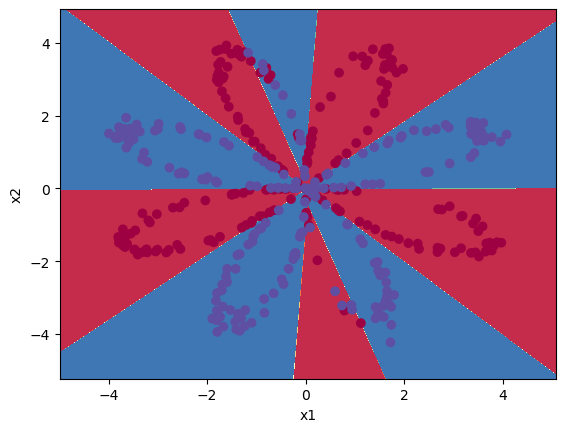

In [21]:
plot_decision_boundary(lambda x: predict(parameters, x.T), X.T, Y.T)

Accuracy

In [22]:
Y_pred = predict(parameters, X)
accuracy = np.mean(Y_pred == Y)
accuracy

0.9525